In [1]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import backend as K
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras import layers
import tensorflow.keras.utils as utils
from vizdoom import DoomGame
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

plt.rcParams["figure.figsize"] = (10, 5)
%matplotlib nbagg

In [2]:
SCREEN_BUFFER_SHAPE = (3, 240, 320)
ACTION_SPACE = 3

PROCESSED_SCREEN_HEIGTH = 120
PROCESSED_SCREEN_WIDTH = 160

FRAMES_PER_ACTION = 6
ACTIONS = [[1, 0, 0], [0, 1, 0], [0, 0, 1]]

In [20]:
def create_game(display=True):
    game = DoomGame()
    game.load_config("../scenarios/health_gathering.cfg")
    game.set_doom_scenario_path("../scenarios/health_gathering.wad")
    #game.set_render_hud(True)
    game.set_window_visible(display)
    game.init()
    
    return game

In [4]:
#def custom_loss_function(y_true, y_pred):
def custom_loss_function(reward, action_prob):
    loss = K.log(action_prob) * reward
    loss = K.sum(loss)
    return - loss

In [5]:
def play_randomly(game, actions):
    game.set_render_hud(True)
    game.new_episode()
    while not game.is_episode_finished():
        state = game.get_state()
        img = state.screen_buffer
        misc = state.game_variables
        reward = game.make_action(random.choice(actions), FRAMES_PER_ACTION)
    game.get_total_reward()

In [6]:
#game, actions = create_game()
#play_randomly(game, actions)
#game.close()

In [7]:
def preprocess_screen(screen, width=PROCESSED_SCREEN_WIDTH, height=PROCESSED_SCREEN_HEIGTH):
    # vizdoom used channel-first, cv2 uses channel-last
    screen = screen.transpose((1, 2, 0))
    # grayscale
    screen = cv2.cvtColor(screen, cv2.COLOR_BGR2GRAY)
    # resize
    screen = cv2.resize(screen, (width, height))
    # normalize
    screen = screen / 255.0
    return screen

In [8]:
def create_model(input_width=PROCESSED_SCREEN_WIDTH, input_height=PROCESSED_SCREEN_HEIGTH, action_space=ACTION_SPACE):
    # screen-input and conv_layers
    screen_input = Input((input_height, input_width, 1))
    conv_layers = Conv2D(32, kernel_size=(3, 3), activation="relu")(screen_input)
    conv_layers = MaxPooling2D(pool_size=(2, 2))(conv_layers)
    conv_layers = Conv2D(32, kernel_size=(3, 3), activation="relu")(conv_layers)
    conv_layers = MaxPooling2D(pool_size=(2, 2))(conv_layers)
    conv_layers = Conv2D(32, kernel_size=(3, 3), activation="relu")(conv_layers)
    conv_layers = MaxPooling2D(pool_size=(2, 2))(conv_layers)
    conv_layers = Conv2D(32, kernel_size=(3, 3), activation="relu")(conv_layers)
    conv_layers = MaxPooling2D(pool_size=(2, 2))(conv_layers)
    conv_layers = Flatten()(conv_layers)
    
    # health input
    health_input = Input((1,))
    
    # concat and add some dense layers for good measure
    dense_layers = layers.concatenate([conv_layers, health_input])
    dense_layers = Dense(16, activation='relu')(dense_layers)
    dense_layers = Dense(16, activation='relu')(dense_layers)
    dense_layers = Dense(16, activation='relu')(dense_layers)
    
    # finalize
    output = Dense(action_space, activation='softmax')(dense_layers)
    model = keras.Model(inputs=[screen_input, health_input], outputs=output)
    model.compile(optimizer='adam', loss=custom_loss_function)
    return model

In [9]:
def take_probabilistic_action(model, formated_state):
    probabilities = model.predict(formated_state)
    action = np.random.choice(ACTION_SPACE, p=probabilities[0])
    return action

In [10]:
def play_and_display(game, model):
    game.new_episode()
    while not game.is_episode_finished():
        state = game.get_state()
        screen = preprocess_screen(game.get_state().screen_buffer)
        health = game.get_state().game_variables        
        action = take_probabilistic_action(model, [np.array([screen]), np.array([health])])        
        reward = game.make_action(actions[action], FRAMES_PER_ACTION)
    return game.get_total_reward()

In [11]:
#game, actions = create_game()
#model = create_model()
#play_and_display(game, model)
#game.close()

In [12]:
def format_rewards(action_history, reward_history, action_space=3):
    formated_ah = utils.to_categorical(action_history, num_classes=action_space)
    formated_rw = np.full((action_space, reward_history.shape[0]), reward_history).T
    return formated_ah * formated_rw

In [13]:
def compute_discounted_reward(reward_history, discount_rate=0.99):
    discounted_rewards = []
    discounted_sum = 0
    for r in reward_history[::-1]:
        discounted_sum = r + discount_rate * discounted_sum
        discounted_rewards.insert(0, discounted_sum)
        
    # use simple Baseline
    discounted_rewards = (discounted_rewards - np.mean(discounted_rewards)) / np.std(discounted_rewards)
    
    return discounted_rewards

In [14]:
def train(game, model):
    game.new_episode()
    action_history = []
    reward_history = []
    # state history
    screen_history = []
    health_history = []

    while not game.is_episode_finished():
        state = game.get_state()
        
        screen = preprocess_screen(game.get_state().screen_buffer)
        health = game.get_state().game_variables
        screen_history.append(screen)
        health_history.append(health)
    
        action = take_probabilistic_action(model, [np.array([screen]), np.array([health])])
        action_history.append(action)
        reward = game.make_action(actions[action], FRAMES_PER_ACTION)
        reward_history.append(reward)
    
    # update weights
    loss = model.train_on_batch(
        x = [np.array(screen_history), np.array(health_history)],
        y = format_rewards(action_history, compute_discounted_reward(reward_history)))
    
    return (loss, game.get_total_reward())

## Training

In [22]:
#game, actions = create_game(display=False)
model = create_model()
total_reward_history = []

<IPython.core.display.Javascript object>


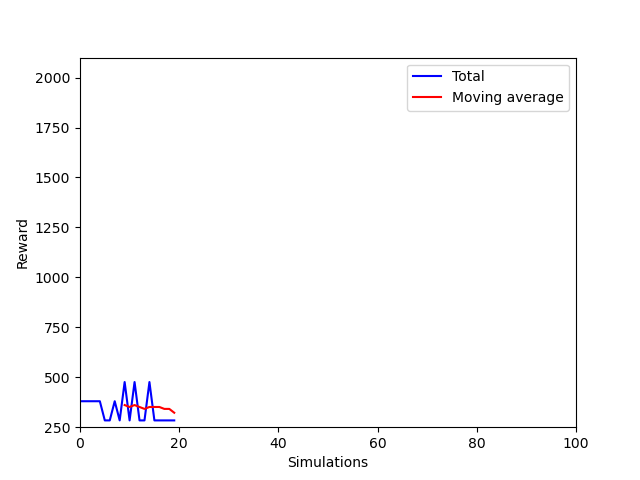

In [18]:
fig = plt.figure()
ax = fig.add_subplot(111)
line1, = ax.plot(total_reward_history, color="blue", label="Total")
line2, = ax.plot([], color="red", label="Moving average")
ax.set_xlim(0, 100)
ax.set_ylim(250, 2100)
ax.set_xlabel("Simulations")
ax.set_ylabel("Reward")
ax.legend()

for i in range(10):
    loss, total_reward = train(game, model)
    total_reward_history.append(total_reward)
    
    # draw dynamic plot just because we can
    line1.set_xdata(np.arange(len(total_reward_history)))
    line1.set_ydata(total_reward_history)
    line2.set_xdata(np.arange(len(total_reward_history)))
    line2.set_ydata(pd.DataFrame(total_reward_history).rolling(window=10).mean())
    fig.canvas.draw()
    fig.canvas.flush_events()

In [ ]:
game.close()
game, actions = create_game(display=True)
play_and_display(game, model)
game.close()

## New Stuff

In [15]:
class History:
    def __init__(self):
        self.screen = []
        self.health = []
        self.action = []
        self.reward = []

    def append(self, screen, health, action, reward):
        self.screen.append(screen)
        self.health.append(health)
        self.action.append(action)
        self.reward.append(reward)

In [24]:
def create_batch(model_weights):
    game = create_game()
    model = create_model()
    model.set_weights(model_weights)
    history = History()

    while not game.is_episode_finished():
        state = game.get_state()
        screen = preprocess_screen(game.get_state().screen_buffer)
        health = game.get_state().game_variables
        action = take_probabilistic_action(model, [np.array([screen]), np.array([health])])
        reward = game.make_action(ACTIONS[action], FRAMES_PER_ACTION)
        history.append(screen, health, action, reward)

    return history

In [25]:
h1 = create_batch(model.get_weights())
h2 = create_batch(model.get_weights())
histories = [h1, h2]

In [36]:
cv2.imshow("image", h.screen[0])
cv2.waitKey(0)
cv2.destroyAllWindows() 

In [45]:
len(h2.screen)

64

In [51]:
herp = [h1, h2, None]

In [32]:
x1 = np.vstack(
    [histories[i].screen for i in range(len(histories))]
)

x2 = np.vstack(
    [histories[i].health for i in range(len(histories))]
)

model.predict([x1, x2]).shape

AttributeError: 'NoneType' object has no attribute 'screen'

In [48]:
[h for h in filter(lambda h: isinstance(h, History), histories)]
#[for i in filter(lambda h: isinstance(h, History), histories)]:
#    print(i)
#1 if isinstance(None, History) else 0

[<__main__.History at 0x1bacdfe7f88>, <__main__.History at 0x1bace1b3948>]

In [50]:
def update_weights(histories):
    histories = [h for h in filter(lambda h: isinstance(h, History), histories)]
    return histories

In [52]:
update_weights(herp)

[<__main__.History at 0x1bacdfe7f88>, <__main__.History at 0x1bace1b3948>]

## Junkyard

In [ ]:
#cv2.imshow("image", screen)
#cv2.waitKey(0)
#cv2.destroyAllWindows() 

In [ ]:
screen = preprocess_screen(game.get_state().screen_buffer)
cv2.imshow("image", screen)
cv2.waitKey(0)
cv2.destroyAllWindows() 

In [ ]:
np.zeros((20, 3))

In [ ]:
advantages = np.zeros((episode_length, self.action_size))

# Episode length is like the minibatch size in DQN
for i in range(episode_length):
    update_inputs[i,:,:,:] = self.states[i]
    advantages[i][self.actions[i]] = discounted_rewards[i]

loss = self.model.fit(update_inputs, advantages, nb_epoch=1, verbose=0)
self.states, self.actions, self.rewards = [], [], []